In [2]:
! rm -rf /kaggle/working/*
#To delete current working Library 

In [1]:
import os
import cv2
import numpy as np
from imgaug import augmenters as iaa
from tqdm import tqdm

# Set paths using your exact structure
input_path = "/kaggle/input/labeled-faces-in-the-wild/LFW_Dataset_11_15/LFW_Dataset_11_15"
output_path = "/kaggle/working/LFW_Processed"
train_path = os.path.join(output_path, "training_data")
test_path = os.path.join(output_path, "testing_data")

# Verify input path exists
if not os.path.exists(input_path):
    print("\nError: Could not find dataset at:", input_path)
    print("\nTrying to locate your dataset...")
    
    # Check possible locations
    base_path = "/kaggle/input"
    if os.path.exists(base_path):
        print("\nContents of /kaggle/input:")
        print(os.listdir(base_path))
        
        if 'labeled-faces-in-the-wild' in os.listdir(base_path):
            wild_path = os.path.join(base_path, 'labeled-faces-in-the-wild')
            print("\nContents of labeled-faces-in-the-wild:")
            print(os.listdir(wild_path))
            
            if 'LFW_Dataset_11_15' in os.listdir(wild_path):
                dataset_path = os.path.join(wild_path, 'LFW_Dataset_11_15')
                print("\nContents of LFW_Dataset_11_15:")
                print(os.listdir(dataset_path))
    
    raise FileNotFoundError(f"Could not find dataset at: {input_path}\nPlease verify the path and try again.")

print(f"\nDataset found at: {input_path}")
print("Processing...")

# Create output directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Augmentation setup
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Affine(
        rotate=(-20, 20),
        scale=(0.8, 1.2),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    ),
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.LinearContrast((0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))
])

def augment_image(image, num_augmentations):
    """Generate augmented versions of an image"""
    augmented_images = []
    for _ in range(num_augmentations):
        augmented = augmentation(image=image)
        augmented_images.append(augmented)
    return augmented_images

def process_person(person_dir, person_name):
    """Process images for one person"""
    image_files = [f for f in os.listdir(person_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    original_images = []
    
    for img_file in image_files:
        img_path = os.path.join(person_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            original_images.append(img)
    
    num_images = len(original_images)
    
    # Augment if needed to reach 15 images
    if num_images < 15:
        needed = 15 - num_images
        augmented_images = []
        
        # Distribute augmentations across original images
        per_image = max(1, needed // num_images)
        remainder = needed % num_images
        
        for i, img in enumerate(original_images):
            to_generate = per_image + (1 if i < remainder else 0)
            if to_generate > 0:
                augmented_images.extend(augment_image(img, to_generate))
        
        all_images = original_images + augmented_images
    else:
        all_images = original_images[:15]  # Take first 15 if more available
    
    # Shuffle and split
    np.random.shuffle(all_images)
    train_images = all_images[:10]
    test_images = all_images[10:15]
    
    return train_images, test_images

def save_images(images, output_dir, person_name, prefix):
    """Save images to appropriate directory"""
    person_output_dir = os.path.join(output_dir, person_name)
    os.makedirs(person_output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        output_path = os.path.join(person_output_dir, f"{prefix}_{i+1:02d}.jpg")
        cv2.imwrite(output_path, img)

# Get all person folders
person_folders = [d for d in os.listdir(input_path) 
                 if os.path.isdir(os.path.join(input_path, d))]

print(f"\nFound {len(person_folders)} persons to process")

# Process each person
for person in tqdm(person_folders, desc="Processing persons"):
    person_dir = os.path.join(input_path, person)
    train_imgs, test_imgs = process_person(person_dir, person)
    
    # Save images
    save_images(train_imgs, train_path, person, "train")
    save_images(test_imgs, test_path, person, "test")

print("\nProcessing complete!")
print(f"Training data saved to: {train_path}")
print(f"Testing data saved to: {test_path}")
print(f"\nTotal persons processed: {len(person_folders)}")
print(f"Training images per person: 10")
print(f"Testing images per person: 5")


Dataset found at: /kaggle/input/labeled-faces-in-the-wild/LFW_Dataset_11_15/LFW_Dataset_11_15
Processing...

Found 58 persons to process


Processing persons: 100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


Processing complete!
Training data saved to: /kaggle/working/LFW_Processed/training_data
Testing data saved to: /kaggle/working/LFW_Processed/testing_data

Total persons processed: 58
Training images per person: 10
Testing images per person: 5


In [4]:
!pip install facenet-pytorch
!pip uninstall pillow -y
!pip install --no-cache-dir pillow
!pip install expecttest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━

In [5]:
## Extract Feature function using INceptionResnet V1 

# Shared feature extraction block (run this once before any classifier training)

import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm

# Paths
data_dir_train = "/kaggle/working/LFW_Processed/training_data"
data_dir_test = "/kaggle/working/LFW_Processed/testing_data"

# Load model
model = InceptionResnetV1(pretrained='vggface2').eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Feature extraction
def extract_features(data_dir):
    features, labels = [], []
    for label in tqdm(os.listdir(data_dir), desc=f"Extracting from {data_dir}"):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img_tensor = preprocess_image(img_path)
                with torch.no_grad():
                    feature = model(img_tensor).numpy().flatten()
                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Extract and store in shared variables
X_train, y_train = extract_features(data_dir_train)
X_test, y_test = extract_features(data_dir_test)


  0%|          | 0.00/107M [00:00<?, ?B/s]

Extracting from /kaggle/working/LFW_Processed/training_data: 100%|██████████| 58/58 [00:39<00:00,  1.46it/s]
Extracting from /kaggle/working/LFW_Processed/testing_data: 100%|██████████| 58/58 [00:20<00:00,  2.87it/s]


InceptionresnetV1 for SVM 

In [6]:
import PIL
print(PIL.__version__)


11.0.0


Accuracy: 0.9724
Classification Report:
                            precision    recall  f1-score   support

             Adrien_Brody       0.83      1.00      0.91         5
             Andy_Roddick       1.00      1.00      1.00         5
              Ann_Veneman       1.00      1.00      1.00         5
          Anna_Kournikova       0.83      1.00      0.91         5
            Ari_Fleischer       1.00      1.00      1.00         5
               Bill_Simon       1.00      1.00      1.00         5
           Britney_Spears       1.00      1.00      1.00         5
     Catherine_Zeta-Jones       1.00      1.00      1.00         5
            Charles_Moose       1.00      1.00      1.00         5
         Condoleezza_Rice       1.00      1.00      1.00         5
         David_Nalbandian       1.00      1.00      1.00         5
              Dick_Cheney       1.00      0.80      0.89         5
    Dominique_de_Villepin       1.00      1.00      1.00         5
           Edmund_St

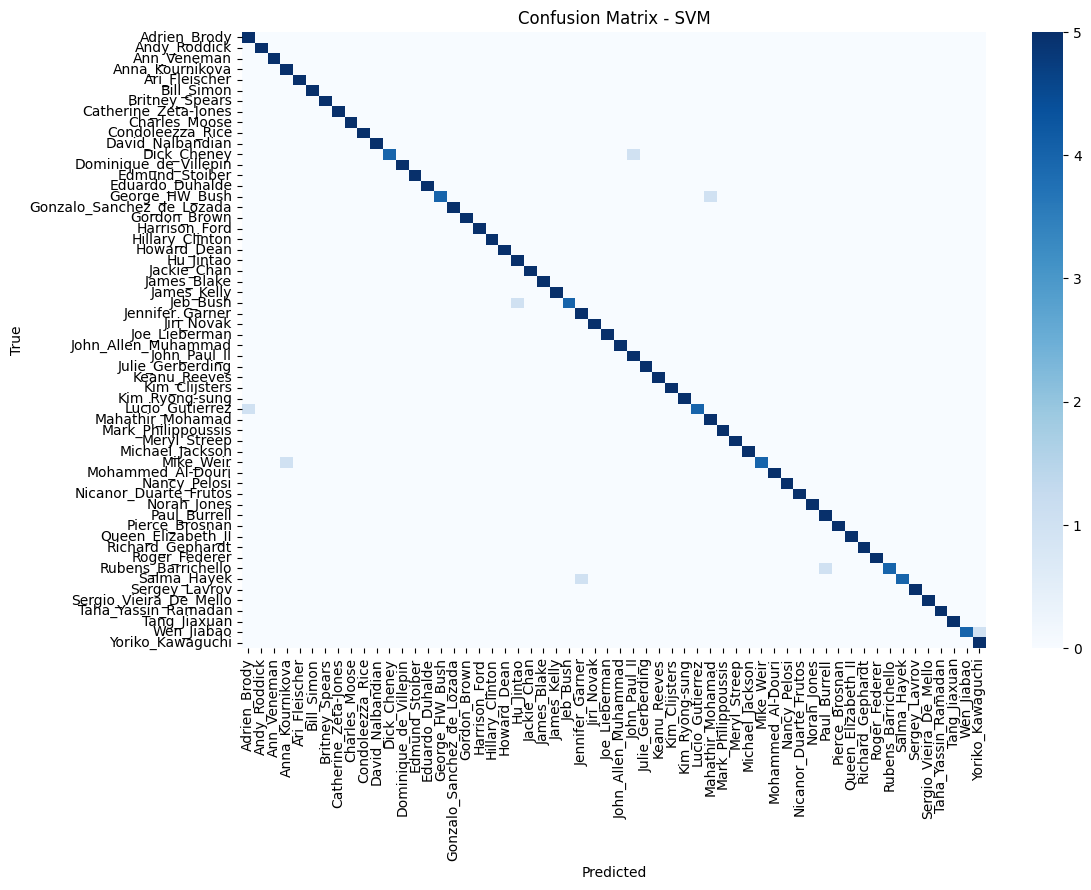

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

svm_clf = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()


In [8]:
model_path = "SVM.pth"


torch.save(svm_clf,model_path)

InceptionresnetV1 for Random Forest

Accuracy: 0.9517
Classification Report:
                            precision    recall  f1-score   support

             Adrien_Brody       1.00      1.00      1.00         5
             Andy_Roddick       0.83      1.00      0.91         5
              Ann_Veneman       1.00      1.00      1.00         5
          Anna_Kournikova       0.75      0.60      0.67         5
            Ari_Fleischer       1.00      1.00      1.00         5
               Bill_Simon       1.00      1.00      1.00         5
           Britney_Spears       1.00      1.00      1.00         5
     Catherine_Zeta-Jones       1.00      1.00      1.00         5
            Charles_Moose       1.00      1.00      1.00         5
         Condoleezza_Rice       1.00      1.00      1.00         5
         David_Nalbandian       1.00      1.00      1.00         5
              Dick_Cheney       0.80      0.80      0.80         5
    Dominique_de_Villepin       1.00      1.00      1.00         5
           Edmund_St

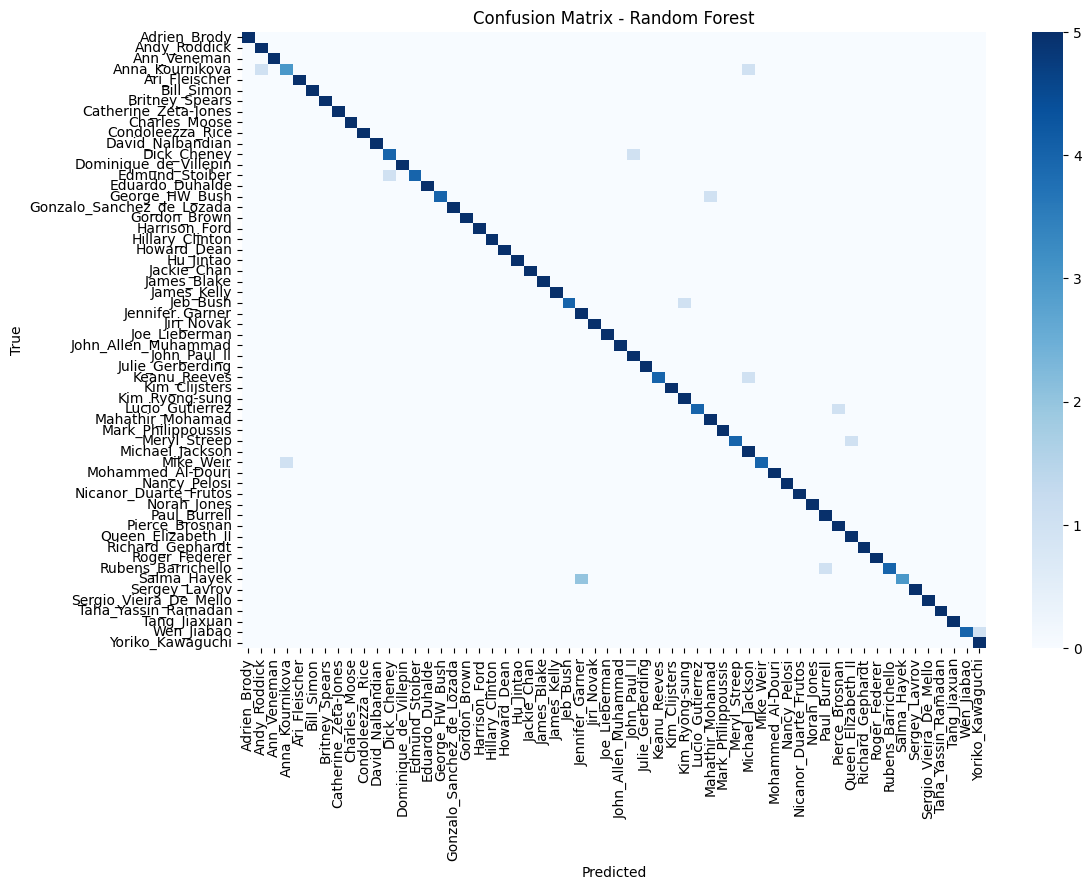

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [11]:
model_path = "Random_forest.pth"


torch.save(rf_clf,model_path)

Inception resnet V1 for Logistic 

Accuracy: 0.9621
Classification Report:
                            precision    recall  f1-score   support

             Adrien_Brody       0.83      1.00      0.91         5
             Andy_Roddick       0.83      1.00      0.91         5
              Ann_Veneman       1.00      1.00      1.00         5
          Anna_Kournikova       0.67      0.40      0.50         5
            Ari_Fleischer       1.00      1.00      1.00         5
               Bill_Simon       1.00      1.00      1.00         5
           Britney_Spears       1.00      1.00      1.00         5
     Catherine_Zeta-Jones       1.00      1.00      1.00         5
            Charles_Moose       1.00      1.00      1.00         5
         Condoleezza_Rice       1.00      1.00      1.00         5
         David_Nalbandian       1.00      1.00      1.00         5
              Dick_Cheney       1.00      0.80      0.89         5
    Dominique_de_Villepin       1.00      1.00      1.00         5
           Edmund_St

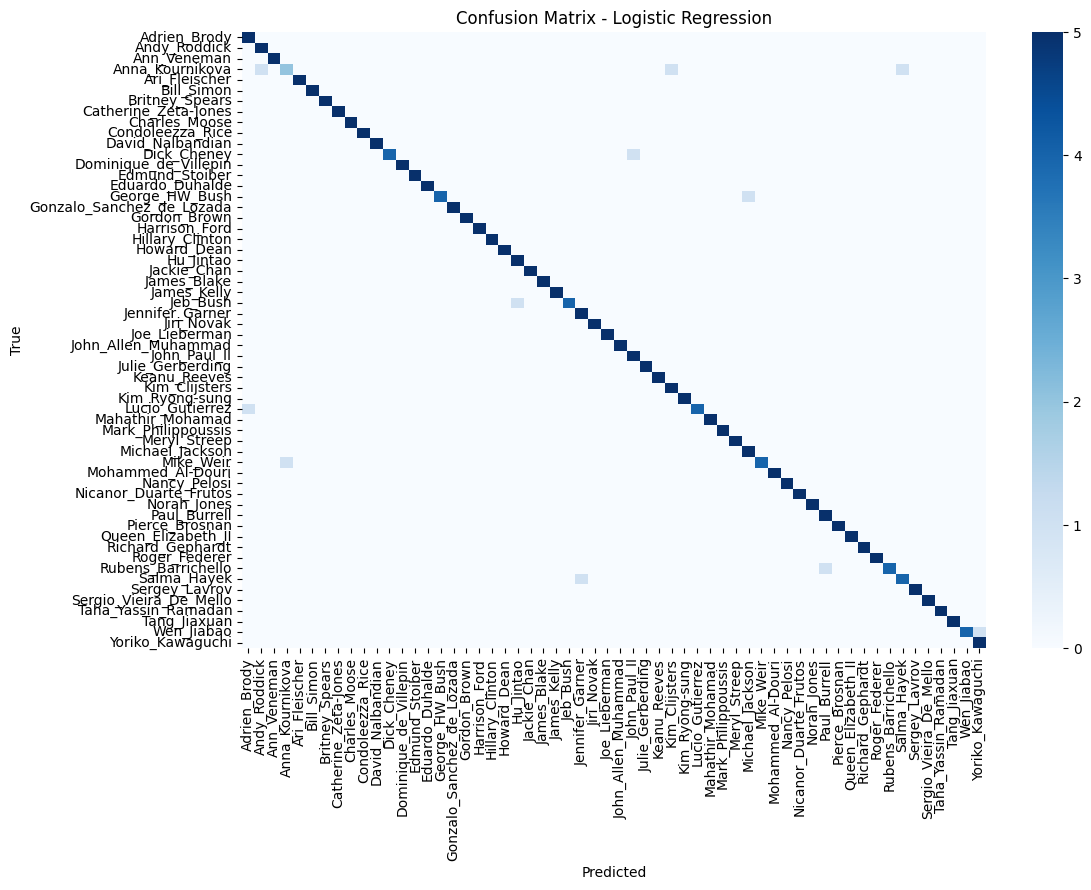

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


In [13]:
model_path = "Logistic.pth"


torch.save(log_reg,model_path)

Inception resnet v1

Learning rate scheduling 

Epoch 1/100, Loss: 3.6422, Accuracy: 0.1362, Precision: 0.1233
Epoch 2/100, Loss: 2.4921, Accuracy: 0.5569, Precision: 0.5806
Epoch 3/100, Loss: 1.7754, Accuracy: 0.7241, Precision: 0.7430
Epoch 4/100, Loss: 1.2902, Accuracy: 0.8103, Precision: 0.8230
Epoch 5/100, Loss: 1.1450, Accuracy: 0.8310, Precision: 0.8480
Epoch 6/100, Loss: 0.9293, Accuracy: 0.8414, Precision: 0.8507
Epoch 7/100, Loss: 0.9756, Accuracy: 0.8103, Precision: 0.8251
Epoch 8/100, Loss: 0.8764, Accuracy: 0.8414, Precision: 0.8469
Epoch 9/100, Loss: 0.7394, Accuracy: 0.8655, Precision: 0.8749
Epoch 10/100, Loss: 0.6667, Accuracy: 0.8724, Precision: 0.8806
Epoch 11/100, Loss: 0.6248, Accuracy: 0.8759, Precision: 0.8822
Epoch 12/100, Loss: 0.6380, Accuracy: 0.8741, Precision: 0.8819
Epoch 13/100, Loss: 0.6539, Accuracy: 0.8431, Precision: 0.8508
Epoch 14/100, Loss: 0.5727, Accuracy: 0.8810, Precision: 0.8859
Epoch 15/100, Loss: 0.5575, Accuracy: 0.8862, Precision: 0.8926
Epoch 16/100, Loss: 0.5418, Accuracy: 0.8948, Pre

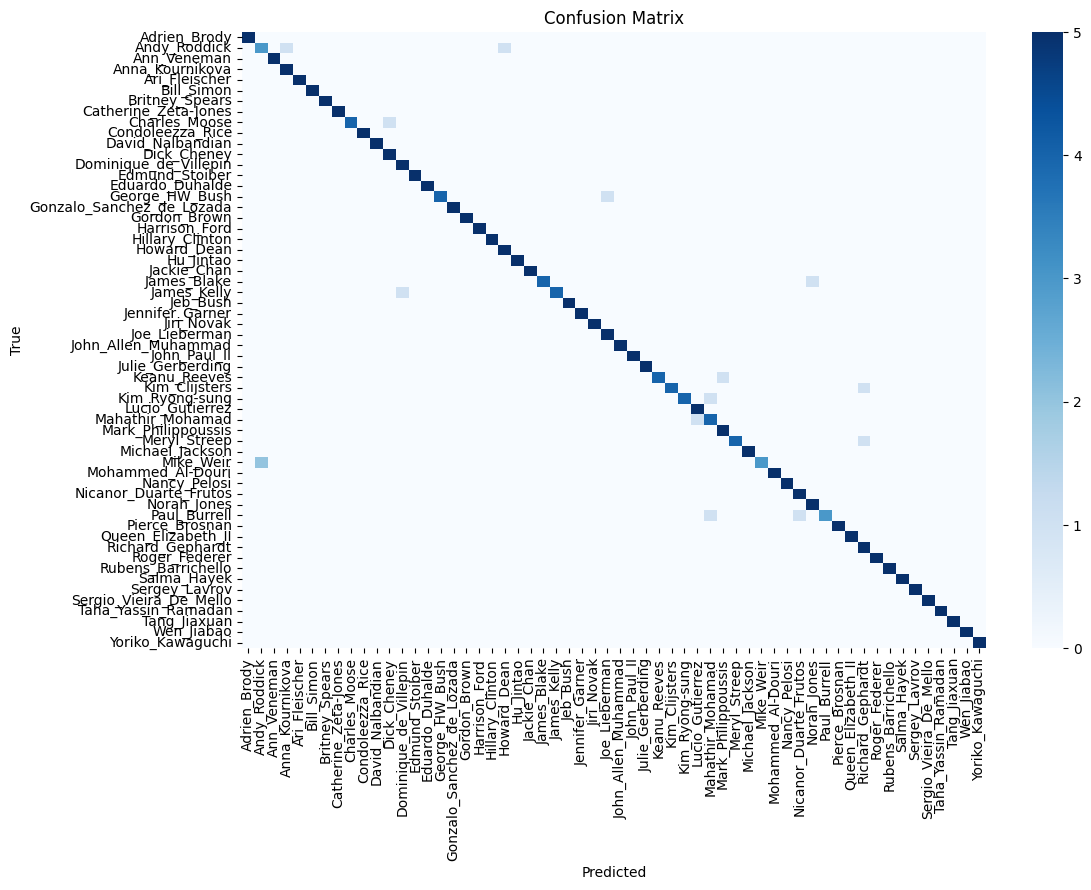

In [14]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

# Paths
data_dir_train = "/kaggle/working/LFW_Processed/training_data"
data_dir_test = "/kaggle/working/LFW_Processed/testing_data"
label_csv = "/kaggle/input/labeled-faces-in-the-wild/LFW Labels.csv"

# Load label mapping
label_df = pd.read_csv(label_csv)
index_to_name = dict(zip(label_df['Index'], label_df['Folder Name']))
name_to_index = {v: k for k, v in index_to_name.items()}

# Image dataset class
class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        for label in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    self.samples.append((os.path.join(label_path, img_name), name_to_index[label]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = FaceDataset(data_dir_train, transform)
test_dataset = FaceDataset(data_dir_test, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load InceptionResNetV1 model with fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=len(name_to_index)).to(device)

# **FIX: Unfreeze only the classification layer first**
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
for param in model.logits.parameters():
    param.requires_grad = True  # Train only classification layer

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        all_preds, all_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}, Precision: {epoch_precision:.4f}")
        
        # Step scheduler after every epoch
        scheduler.step()

# **Phase 1: Train only classification layer**
train(model, train_loader, criterion, optimizer, scheduler, epochs=100)

# **Unfreeze all layers for fine-tuning**
for param in model.parameters():
    param.requires_grad = True

# **Reinitialize optimizer with all layers trainable**
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# **Phase 2: Fine-tune full model**
train(model, train_loader, criterion, optimizer, scheduler, epochs=200)

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions
y_pred, y_true = evaluate(model, test_loader)

# Compute accuracy and precision
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
print(f"Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=[index_to_name[idx] for idx in set(y_true)])
print("Classification Report:\n", report)

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=[index_to_name[i] for i in set(y_true)], yticklabels=[index_to_name[i] for i in set(y_true)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
model_path = "inceptionresnet50v1_400epoch.pth"


torch.save(model,model_path)

In [18]:
!zip -r /kaggle/working/final_package.zip /kaggle/working/SVM.pth /kaggle/working/Random_forest.pth /kaggle/working/Logistic.pth /kaggle/working/inceptionresnet50v1_400epoch.pth /kaggle/working/LFW_Processed

updating: kaggle/working/SVM.pth (deflated 53%)
updating: kaggle/working/Random_forest.pth (deflated 95%)
updating: kaggle/working/Logistic.pth (deflated 26%)
updating: kaggle/working/inceptionresnet50v1_400epoch.pth (deflated 7%)
  adding: kaggle/working/LFW_Processed/ (stored 0%)
  adding: kaggle/working/LFW_Processed/training_data/ (stored 0%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/ (stored 0%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/train_10.jpg (deflated 4%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/train_05.jpg (deflated 4%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/train_03.jpg (deflated 4%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/train_08.jpg (deflated 4%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/train_09.jpg (deflated 4%)
  adding: kaggle/working/LFW_Processed/training_data/Bill_Simon/train_04.jpg (deflated 5%)
  adding: kaggle/working/LFW